# Poor Conditioning (Section 4.3)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from linear_regression import LinearRegression

## Data Generation

In [17]:
np.random.seed(2)

total_observations = 1010
num_observations_pop_1 = 10 # A (small fraction)
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

# Generate X values.
mean_pop_1 = np.array([-1])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[.01]])
vars_pop_2 = np.array([[1e-3]])
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x = np.append(x1, x2, axis=0)
x1_0 = [pt[0] for pt in x1]
x2_0 = [pt[0] for pt in x2]

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:10]
x2 = x[10:]

# Generate Y values.
epsilon = np.random.normal(0, 1, num_observations_pop_1) # eps is the variance of the noise distribution.
slope = -1
intercept = -10

y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope*x1_0[i] + intercept + epsilon[i])

y2 = np.random.randn(1, num_observations_pop_2)
y2 = y2[0]
y = np.concatenate([y1, y2], axis=0)

#### Compute Relevant Statistics.

In [45]:
A = np.linalg.inv(x.T @ x)
black_dots_cross_leverage = np.mean([x1[i].T @ A @ x1[j] for i in range(len(x1)) for j in range(i+1, len(x1))])
print(f"Cross leverage score for the 10 black dots: {round(black_dots_cross_leverage, 4)}")
red_crosses_cross_leverage = np.mean([x2[i].T @ A @ x2[j] for i in range(len(x2)) for j in range(i+1, len(x2))])
print(f"Mean cross leverage score for the 1000 red crosses: {round(red_crosses_cross_leverage, 4)}")

Cross leverage score for the 10 black dots: 0.091
Mean cross leverage score for the 1000 red crosses: 0.001


In [46]:
# Compute condition numbers
print(
    f"Condition number of full dataset: {np.linalg.cond(x)}\n"
    f"Condition number Pop A: {np.linalg.cond(x1)} Pop B: {np.linalg.cond(x2)}"
)

Condition number of full dataset: 9.073893742551537
Condition number Pop A: 20.258489328645023 Pop B: 31.680064947455453


## Model Fitting

Fit the data using OLS regression.

In [18]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
modified_lr_a = LinearRegression(x=x1.T, y=y1)
modified_lr_a.fit()
modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}\n"
    f"Estimated beta1 pop A: {modified_lr_a.beta[1]}\n"
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
) 

Estimated beta1 with full dataset: 7.402664577586842
Estimated beta1 pop A: -0.018852211448001577
Estimated beta1 pop B: -1.0492493650237367


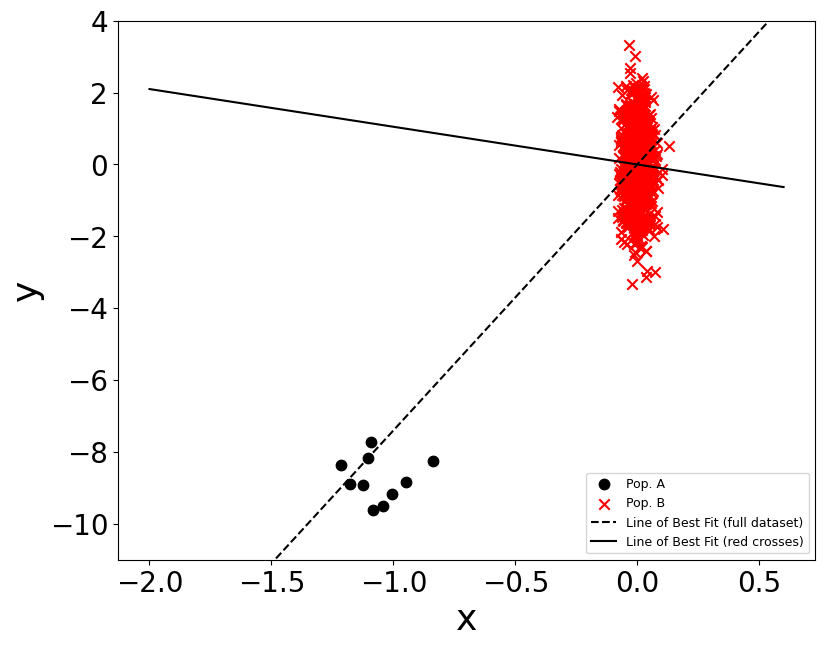

In [19]:
plt.figure(figsize=(9, 7))

plt.scatter(x1[:, 1], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2[:, 1], y2, marker='x', color='r', label='Pop. B', s=56)

x_values = np.linspace(-2, 0.6, 100)
y_values_full = lr.beta[1] * x_values
y_value_red_crosses = modified_lr.beta[1] * x_values
plt.plot(x_values, y_values_full, color='black', linestyle='--', label='Line of Best Fit (full dataset)') 
plt.plot(x_values, y_value_red_crosses, color='black', label='Line of Best Fit (red crosses)')

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

plt.ylim(-11, 4)

plt.xticks(fontsize=20) 
plt.yticks(fontsize=20)

plt.legend(fontsize=9)
# plt.savefig('poor_conditioning_example.pdf')
plt.show()

## Additive and Greedy algorithms.

In [6]:
def compute_scores(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression model.
    '''
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # sort scores according to indices.
    sorted_scores = if_scores[if_inds]
    sorted_newton_scores = newton_scores[newton_inds]

    # compute residuals and leverages.
    residuals = lr.residual()
    leverages = lr.leverage_scores()

    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x1, 'y': y, 
                            'residual': residuals, 'leverage': leverages, 
                            'IF': if_scores, '1Exact': newton_scores,
                            'sorted_IF_indices': if_inds, 'sorted_1Exact_indices': newton_inds,
                            'sorted_IF_scores': sorted_scores, 'sorted_1Exact_scores': sorted_newton_scores})
    return orig_df

#### Additive Algorithms.

In [7]:
poor_conditioning_df = compute_scores(x, y, lr)
poor_conditioning_df.head(10)

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,-1.041676,-9.512121,-1.798067,0.087423,-0.150910,-0.165367,0,0,-0.150910,-0.165367
1,-1.005627,-9.158502,-1.711308,0.081478,-0.138601,-0.150895,5,5,-0.138603,-0.153103
2,-1.213620,-8.361579,0.625317,0.118695,0.061245,0.069493,1,1,-0.138601,-0.150895
3,-0.835973,-8.250522,-2.059217,0.056343,-0.138307,-0.146565,3,6,-0.138307,-0.146565
4,-1.179344,-8.894897,-0.161736,0.112076,-0.015389,-0.017331,6,3,-0.137491,-0.148266
5,-1.084175,-9.614648,-1.585989,0.094704,-0.138603,-0.153103,7,7,-0.053503,-0.059573
6,-0.949712,-8.832092,-1.798817,0.072676,-0.137491,-0.148266,4,4,-0.015389,-0.017331
7,-1.124529,-8.917402,-0.590015,0.101890,-0.053503,-0.059573,775,775,-0.008193,-0.008205
8,-1.105795,-8.165146,0.023563,0.098521,0.002101,0.002330,237,237,-0.008172,-0.008183
9,-1.090901,-7.730504,0.347946,0.095884,0.030599,0.033844,405,405,-0.006917,-0.006926


In [8]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(poor_conditioning_df["sorted_IF_scores"][:9]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 10 is {round(lr.beta[1] + sum(poor_conditioning_df["sorted_1Exact_scores"][:9]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most 10 is {round((modified_lr.beta[1]), 4)}.')

The AMIP approximation of the refit is 6.6135.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 10 is 6.5452.
The true change induced by dropping the worst-case subset of size at most 10 is -1.0492.


#### Greedy Algorithms.

In [9]:
def create_orig_df(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression object.
    '''
    # compute IF/1Exact scores.
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # residuals
    residuals = lr.residual()
    # leverages
    leverages = lr.leverage_scores()
    # x's
    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': if_scores, 'newton': newton_scores})
    
    print(orig_df[:5])
    return orig_df, if_inds, if_scores, newton_inds, newton_scores

def create_plot(orig_df):
    '''
    orig_df: output from the helper function above.
    '''

    # Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("Point to Drop: ", sorted_if_df.index[0])
    
    # sorted_if_df: the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    sorted_if_df['sorted_idx'] = index
    
    # Plot points dropped
    plt.figure(figsize=(9, 7))
    plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B') # pop B

    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

def Run_Greedy(x, y, orig_if_inds, orig_newton_inds, lr, method='IF'):
    '''
    x: design matrix.
    y: response vector.
    orig_inds: indices sorted by the first round.
    lr: linear regression object.
    method: 'IF' or '1Exact'.
    '''
    ctr = 0
    prev_beta = lr.beta[1] # initialize to the original beta estimate.
    dropped_order = []
    exact_changes_beta = []
    beta_estimates_greedy = []
    if_inds = orig_if_inds
    newton_inds = orig_newton_inds

    for _ in range(11):
        print(f'interation {ctr}')

        if method == 'IF':
            inds = if_inds
        else:
            inds = newton_inds
        
        # 1. drop the datapoint with the most negative influence:
        index_to_remove = inds[0]
        print("index to remove", index_to_remove)

        dropped_order.append(index_to_remove)

        new_x = np.concatenate((x[:index_to_remove], x[index_to_remove + 1:]))
        new_y = np.concatenate((y[:index_to_remove], y[index_to_remove + 1:]))

        x = new_x
        y = new_y

        # 2. calculate the exact perturbation (ie. refit the lr to get the change in the coefficient.)
        lr = LinearRegression(x=x.T, y=y)
        lr.fit()
        print(f'fitted beta1: {lr.beta[1]}')

        # 3. compute scores and create plot.
        orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(x, y, lr)
        create_plot(orig_df)

        # 4. record: the exact change in beta.
        beta_change = lr.beta[1] - prev_beta
        exact_changes_beta.append(beta_change)
        prev_beta = lr.beta[1]
        beta_estimates_greedy.append(lr.beta[1])

        # counter
        ctr += 1

    return dropped_order, exact_changes_beta, beta_estimates_greedy


In [10]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(orig_x, orig_y, lr)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

         x1         y  residual  leverage  influence    newton
0 -1.041676 -9.512121 -1.798067  0.087423  -0.150910 -0.165367
1 -1.005627 -9.158502 -1.711308  0.081478  -0.138601 -0.150895
2 -1.213620 -8.361579  0.625317  0.118695   0.061245  0.069493
3 -0.835973 -8.250522 -2.059217  0.056343  -0.138307 -0.146565
4 -1.179344 -8.894897 -0.161736  0.112076  -0.015389 -0.017331
inds [  0   5   1   3   6   7   4 775 237 405]
newton_inds [  0   5   1   6   3   7   4 775 237 405]


interation 0
index to remove 0
fitted beta1: 7.237297821894756
         x1         y  residual  leverage  influence    newton
0 -1.005627 -9.158502 -1.877599  0.089283  -0.166643 -0.182980
1 -1.213620 -8.361579  0.424631  0.130063   0.045567  0.052380
2 -0.835973 -8.250522 -2.197453  0.061737  -0.161770 -0.172415
3 -1.179344 -8.894897 -0.356753  0.122812  -0.037192 -0.042399
4 -1.084175 -9.614648 -1.765268  0.103777  -0.169043 -0.188618
Point to Drop:  4


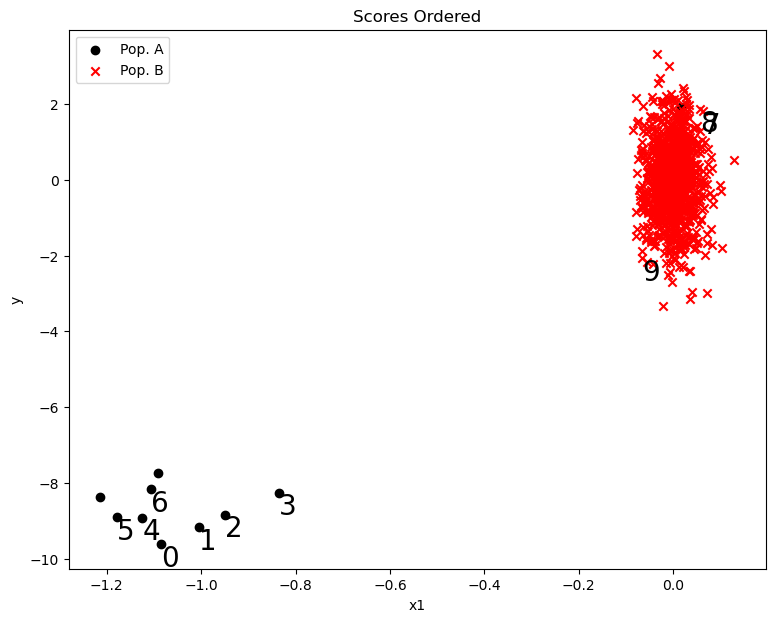

interation 1
index to remove 4
fitted beta1: 7.048680282235854
         x1         y  residual  leverage  influence    newton
0 -1.005627 -9.158502 -2.067189  0.099621  -0.204730 -0.227382
1 -1.213620 -8.361579  0.195809  0.145122   0.023443  0.027422
2 -0.835973 -8.250522 -2.355044  0.068879  -0.193505 -0.207819
3 -1.179344 -8.894897 -0.579110  0.137031  -0.067358 -0.078054
4 -0.949712 -8.832092 -2.134905  0.088857  -0.199565 -0.219027
Point to Drop:  0


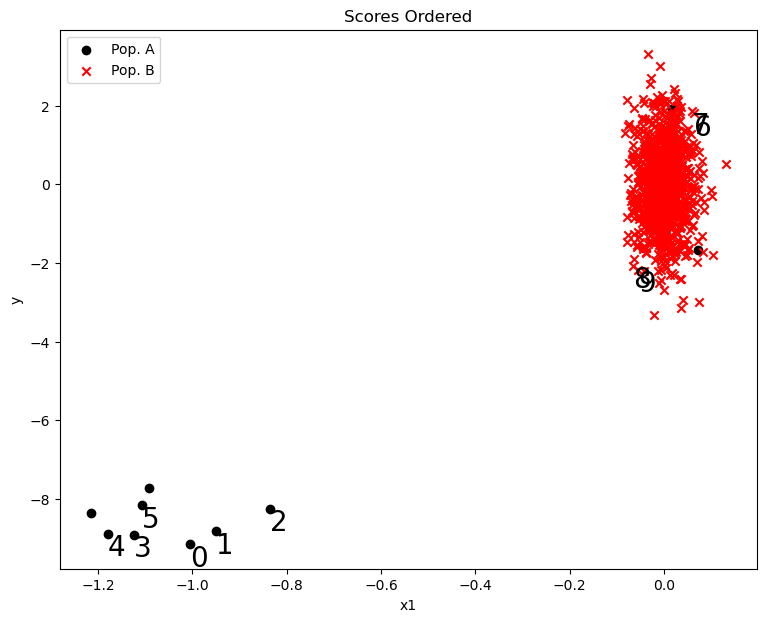

interation 2
index to remove 0
fitted beta1: 6.821298417188832
         x1         y  residual  leverage  influence    newton
0 -1.213620 -8.361579 -0.080206  0.161174  -0.010663 -0.012712
1 -0.835973 -8.250522 -2.545189  0.076497  -0.232314 -0.251558
2 -1.179344 -8.894897 -0.847331  0.152190  -0.109445 -0.129091
3 -0.949712 -8.832092 -2.350912  0.098688  -0.244086 -0.270811
4 -1.124529 -8.917402 -1.243743  0.138361  -0.153124 -0.177713
Point to Drop:  3


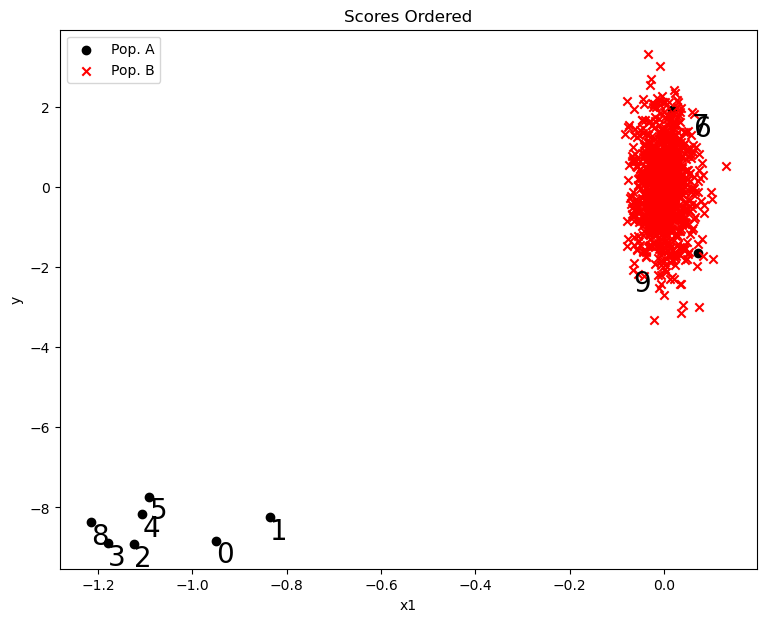

interation 3
index to remove 3
fitted beta1: 6.550486937974007
         x1         y  residual  leverage  influence    newton
0 -1.213620 -8.361579 -0.409085  0.178813  -0.060328 -0.073464
1 -0.835973 -8.250522 -2.771797  0.084872  -0.280738 -0.306774
2 -1.179344 -8.894897 -1.166928  0.168847  -0.167196 -0.201161
3 -1.124529 -8.917402 -1.548495  0.153507  -0.211485 -0.249837
4 -1.105795 -8.165146 -0.918954  0.148433  -0.123400 -0.144910
Point to Drop:  1


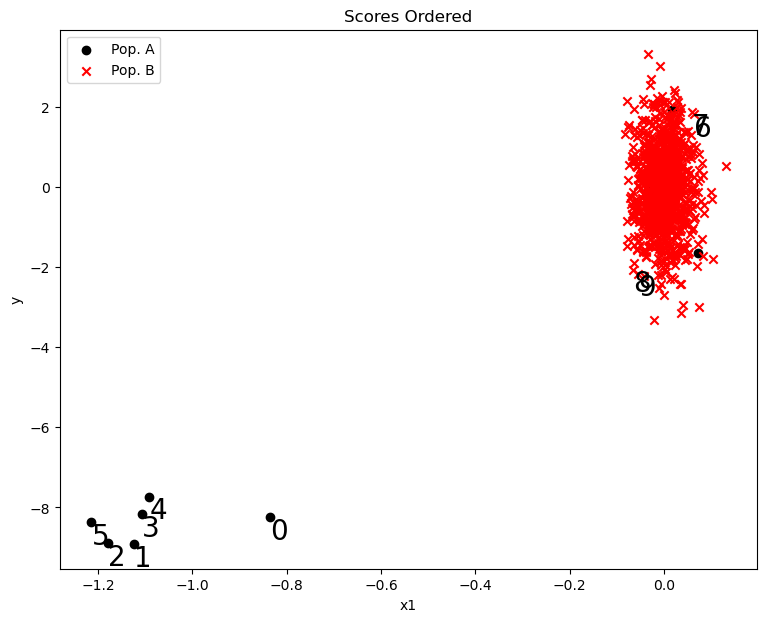

interation 4
index to remove 1
fitted beta1: 6.243712631418109
         x1         y  residual  leverage  influence    newton
0 -1.213620 -8.361579 -0.782002  0.195378  -0.125978 -0.156568
1 -1.179344 -8.894897 -1.529330  0.184491  -0.239372 -0.293525
2 -1.124529 -8.917402 -1.894081  0.167733  -0.282602 -0.339557
3 -1.105795 -8.165146 -1.258792  0.162189  -0.184667 -0.220416
4 -1.090901 -7.730504 -0.917147  0.157849  -0.132723 -0.157600
Point to Drop:  2


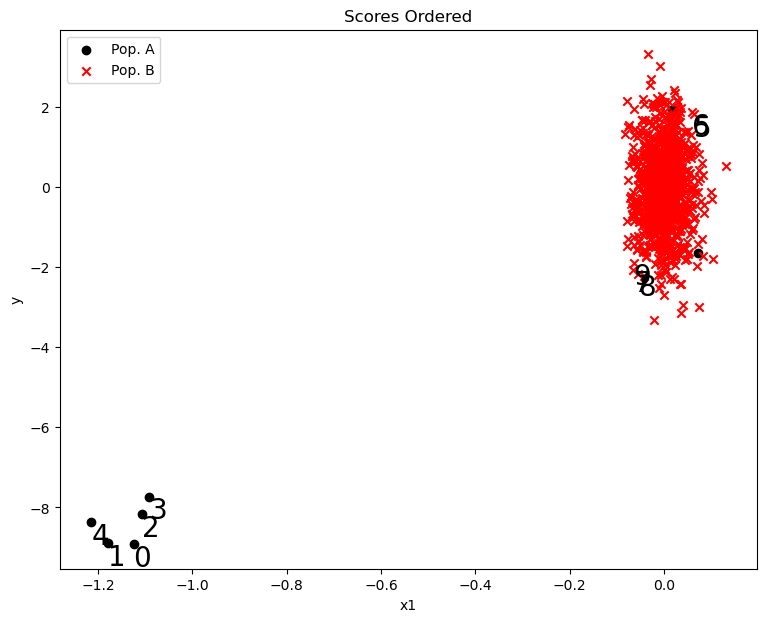

interation 5
index to remove 2
fitted beta1: 5.904155963269849
         x1         y  residual  leverage  influence    newton
0 -1.213620 -8.361579 -1.193980  0.234752  -0.231095 -0.301987
1 -1.179344 -8.894897 -1.929670  0.221672  -0.362888 -0.466241
2 -1.105795 -8.165146 -1.634159  0.194876  -0.288054 -0.357776
3 -1.090901 -7.730504 -1.287456  0.189661  -0.223867 -0.276264
4  0.017439  1.915679  1.814919  0.001083  -0.006786 -0.006793
Point to Drop:  1


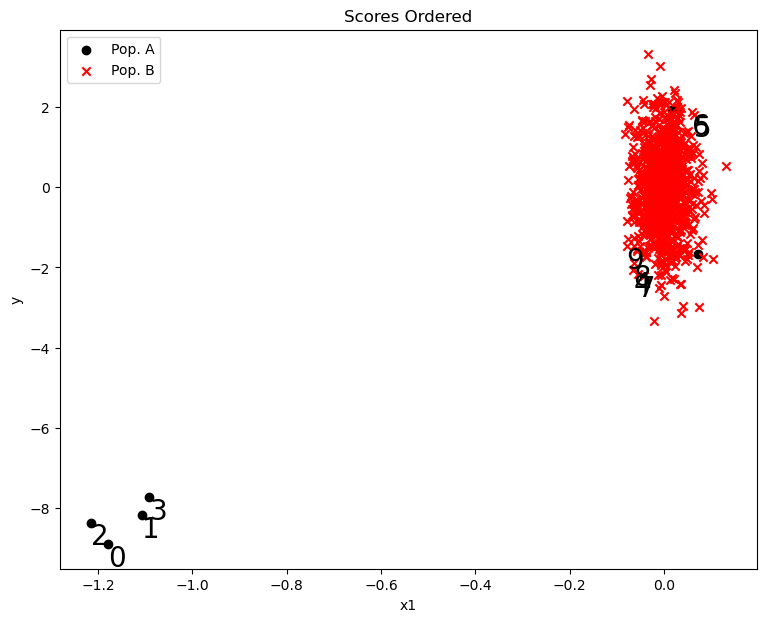

interation 6
index to remove 1
fitted beta1: 5.437915365675767
         x1         y  residual  leverage  influence    newton
0 -1.213620 -8.361579 -1.759542  0.301611  -0.437541 -0.626499
1 -1.105795 -8.165146 -2.149448  0.250377  -0.486824 -0.649426
2 -1.090901 -7.730504 -1.795801  0.243676  -0.401226 -0.530494
3  0.017439  1.915679  1.823326  0.001098  -0.008311 -0.008320
4  0.072486 -1.660405 -2.052101  0.002223   0.032590  0.032663
Point to Drop:  1


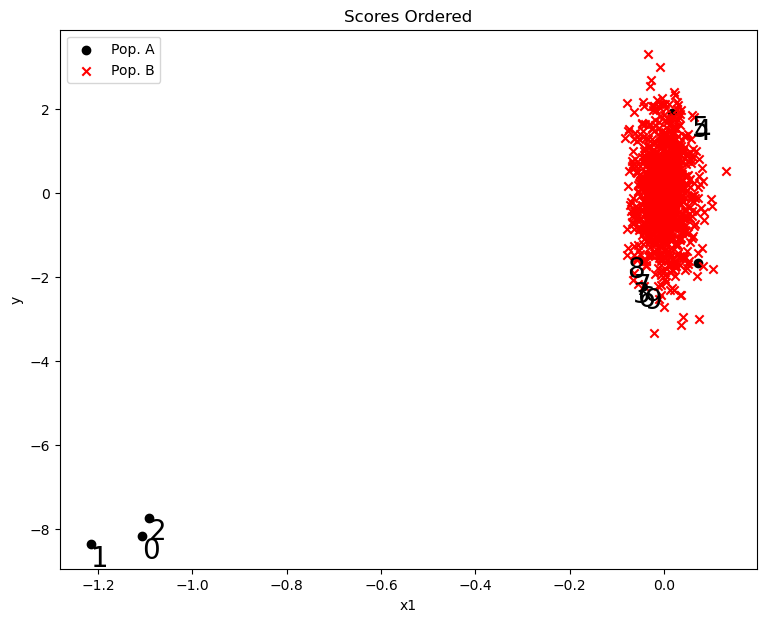

interation 7
index to remove 1
fitted beta1: 4.788489548736089
         x1         y  residual  leverage  influence    newton
0 -1.213620 -8.361579 -2.547491  0.402347  -0.844987 -1.413840
1 -1.090901 -7.730504 -2.504053  0.325065  -0.746341 -1.105796
2  0.017439  1.915679  1.834859  0.001120  -0.010593 -0.010605
3  0.072486 -1.660405 -2.004819  0.002586   0.041827  0.041936
4  0.001314 -0.492985 -0.496592  0.001005   0.000672  0.000673
Point to Drop:  0


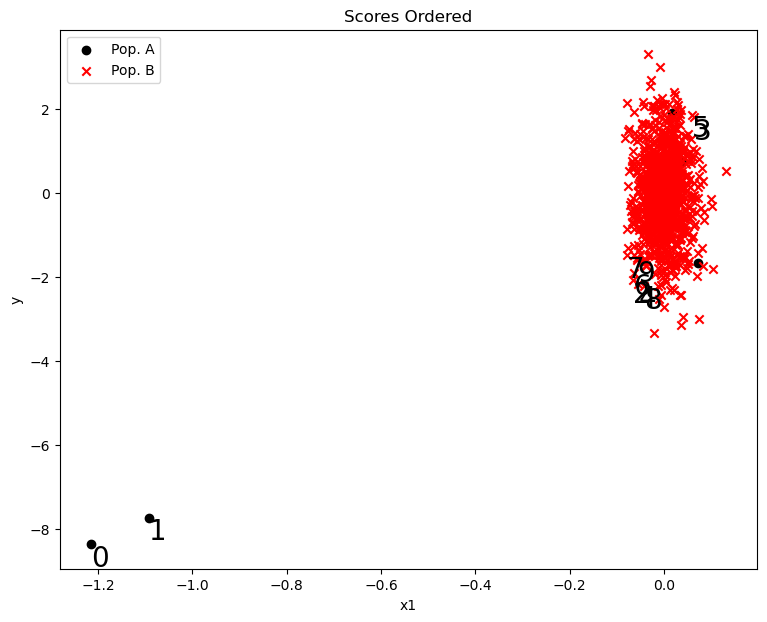

interation 8
index to remove 0
fitted beta1: 3.374649144935868
         x1         y  residual  leverage  influence    newton
0 -1.090901 -7.730504 -4.045545  0.543895  -2.017763 -4.423899
1  0.017439  1.915679  1.860381  0.001180  -0.016923 -0.016943
2  0.072486 -1.660405 -1.901469  0.003570   0.065258  0.065492
3  0.001314 -0.492985 -0.493867  0.001005   0.000843  0.000844
4 -0.035352 -0.096082  0.026769  0.001496   0.000404  0.000405
Point to Drop:  0


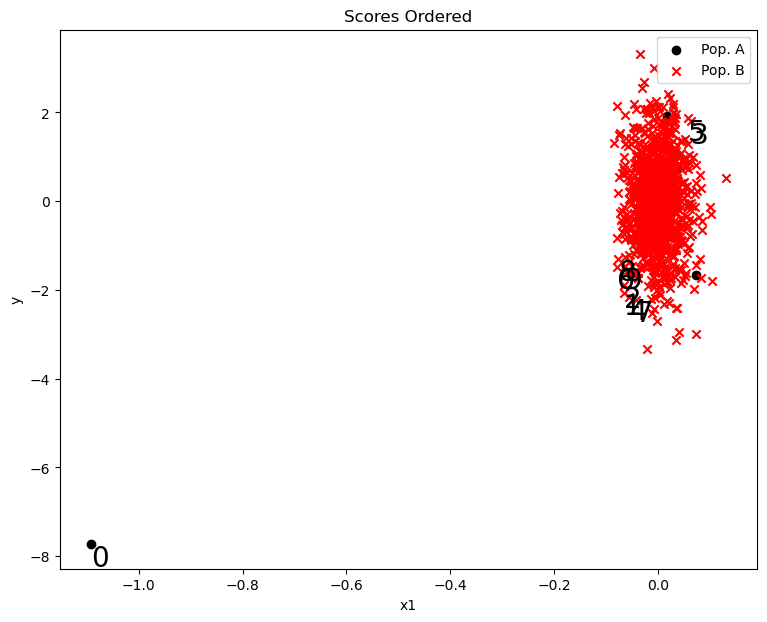

interation 9
index to remove 0
fitted beta1: -1.0492493650237367
         x1         y  residual  leverage  influence    newton
0  0.017439  1.915679  1.939343  0.001353  -0.036521 -0.036570
1  0.072486 -1.660405 -1.578982  0.006468   0.116968  0.117730
2  0.001314 -0.492985 -0.486240  0.001007   0.001288  0.001289
3 -0.035352 -0.096082 -0.127809  0.002162  -0.004365 -0.004374
4  0.017047  0.753658  0.776911  0.001339  -0.014325 -0.014344
Point to Drop:  395


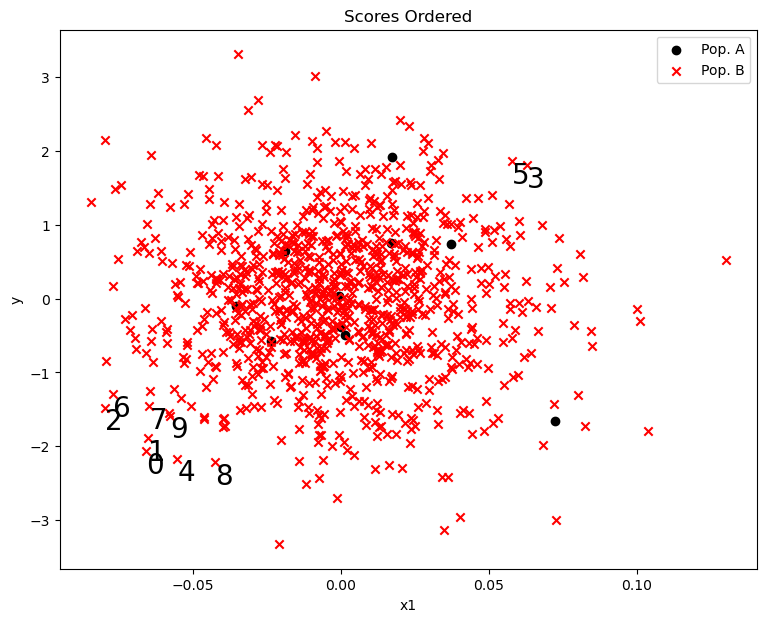

interation 10
index to remove 395
fitted beta1: -1.1874189437970155
         x1         y  residual  leverage  influence    newton
0  0.017439  1.915679  1.939794  0.001353  -0.036555 -0.036605
1  0.072486 -1.660405 -1.570925  0.006482   0.116755  0.117517
2  0.001314 -0.492985 -0.488017  0.001008   0.001266  0.001267
3 -0.035352 -0.096082 -0.134652  0.002172  -0.004626 -0.004636
4  0.017047  0.753658  0.777308  0.001339  -0.014341 -0.014361
Point to Drop:  516


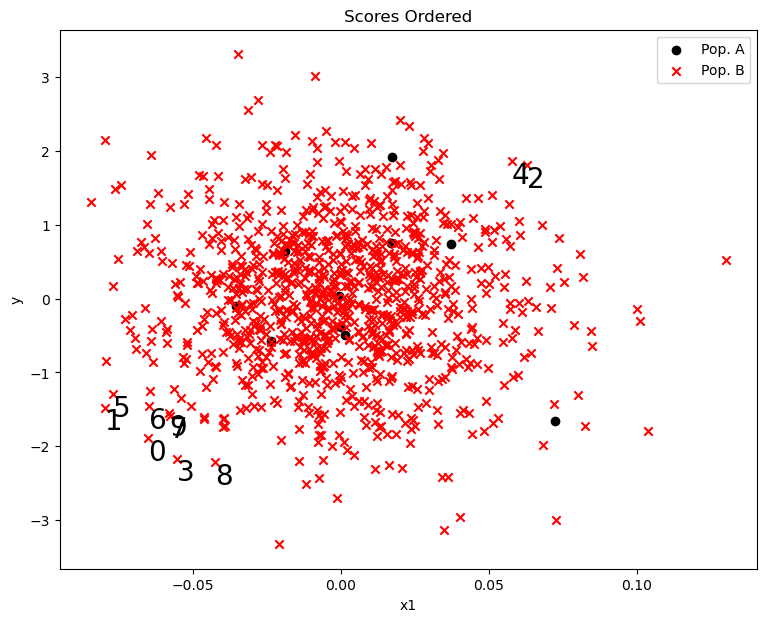

dropped order: 
 [0, 4, 0, 3, 1]
exact (greedy) beta estimates: 
 [7.237297821894756, 7.048680282235854, 6.821298417188832, 6.550486937974007, 6.243712631418109]


In [11]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, method='1Exact')

print("dropped order: \n", dropped_order[:5])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:5])